Starting PSO for clustering...
Iteration 20/100, Best Score: 4.54
Iteration 40/100, Best Score: 4.13
Iteration 60/100, Best Score: 4.09
Iteration 80/100, Best Score: 4.09
Iteration 100/100, Best Score: 4.09
PSO finished.


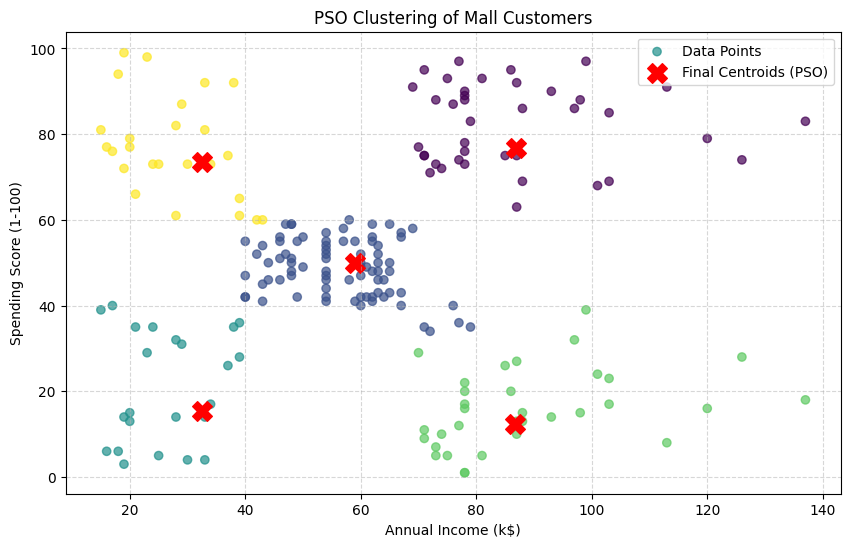

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- 1. Load and Prepare Data ---
raw_df = pd.read_csv("/content/SCOA_A7.csv")
features = raw_df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = MinMaxScaler()
data = scaler.fit_transform(features)

# --- 2. Fitness Function ---
def evaluate(centroids, data):
    """Calculates the Sum of Squared Errors (SSE) for a set of centroids."""
    # Calculate distances from all points to all centroids
    distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
    # Find the squared distance to the nearest centroid for each point
    min_distances_sq = np.min(distances, axis=1)**2
    # Return the sum
    return np.sum(min_distances_sq)

# --- 3. PSO Parameters ---
num_particles = 30
num_iterations = 100
num_clusters = 5
num_dimensions = data.shape[1] # 2
w = 0.5       # inertia weight
c1 = 1.5      # cognitive coefficient
c2 = 1.5      # social coefficient

# --- 4. Initialize Swarm State ---
# Positions: (num_particles, num_clusters, num_dimensions)
positions = np.random.rand(num_particles, num_clusters, num_dimensions) * (data.max(axis=0) - data.min(axis=0)) + data.min(axis=0)
velocities = np.zeros_like(positions)

# Personal best
pbest_positions = np.copy(positions)
pbest_scores = np.array([evaluate(p, data) for p in positions])

# Global best
gbest_idx = np.argmin(pbest_scores)
gbest_position = pbest_positions[gbest_idx]
gbest_score = pbest_scores[gbest_idx]
best_score_history = [gbest_score]

# --- 5. PSO Main Loop ---
print("Starting PSO for clustering...")
for i in range(num_iterations):
    # Calculate fitness for all particles
    scores = np.array([evaluate(p, data) for p in positions])

    # Update personal bests
    mask = scores < pbest_scores
    pbest_scores[mask] = scores[mask]
    pbest_positions[mask] = positions[mask]

    # Update global best
    gbest_idx = np.argmin(pbest_scores)
    gbest_score = pbest_scores[gbest_idx]
    gbest_position = pbest_positions[gbest_idx]
    best_score_history.append(gbest_score)

    # Update particle velocities and positions
    r1 = np.random.rand(num_particles, 1, 1)
    r2 = np.random.rand(num_particles, 1, 1)

    cognitive = c1 * r1 * (pbest_positions - positions)
    social = c2 * r2 * (gbest_position - positions)

    velocities = w * velocities + cognitive + social
    positions += velocities

    if (i+1) % 20 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Best Score: {gbest_score:.2f}")

print("PSO finished.")

# --- 6. Final Plotting ---
# Get final cluster assignments
distances = np.linalg.norm(data[:, None] - gbest_position[None, :], axis=2)
labels = np.argmin(distances, axis=1)

# Inverse transform the centroids to plot them on the *original* scale
global_best_original = scaler.inverse_transform(gbest_position)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=labels, cmap='viridis', alpha=0.7, label='Data Points')
plt.scatter(global_best_original[:, 0], global_best_original[:, 1], s=200, c='red', marker='X', label='Final Centroids (PSO)')
plt.title("PSO Clustering of Mall Customers")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**1. What the Algorithm Does**

This PSO algorithm performs **unsupervised clustering**, similar to K-Means — but instead of randomly adjusting centroids by iteration, it **uses swarm intelligence** to find the best cluster centers (centroids).

Here, the goal is to minimize the **Sum of Squared Errors (SSE)** — i.e., how close data points are to their nearest centroid.

So:

* Each *particle* represents one possible set of centroids.
* The swarm “flies” through the solution space trying to minimize SSE.
* The *best* position found represents the **optimal cluster centroids**.

---
**2. Step-by-Step Explanation of Code**

**Step 1: Load and Preprocess the Data**

```python
raw_df = pd.read_csv("/content/SCOA_A7.csv")
features = raw_df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = MinMaxScaler()
data = scaler.fit_transform(features)
```

* Loads customer data (income and spending score).
* Normalizes values between 0 and 1 (using `MinMaxScaler`) — needed for PSO to perform efficiently.

---

*Step 2: Define Fitness Function**

```python
def evaluate(centroids, data):
    distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
    min_distances_sq = np.min(distances, axis=1)**2
    return np.sum(min_distances_sq)
```

* Measures how good a particular clustering (centroid set) is.
* For every data point, it finds the nearest centroid and calculates the **squared distance**.
* The smaller the total sum, the better (i.e., points are closer to centroids).

---

**Step 3: PSO Parameters**

```python
num_particles = 30
num_iterations = 100
num_clusters = 5
```

* `num_particles` → number of candidate centroid sets.
* `num_clusters` → number of groups to form (5).
* `num_iterations` → how many optimization cycles.
* `w`, `c1`, and `c2` control particle motion (inertia, personal, and social learning).

---

**Step 4: Initialize Swarm**

```python
positions = np.random.rand(num_particles, num_clusters, num_dimensions)
velocities = np.zeros_like(positions)
```

* Randomly places each particle in the feature space (initial guess of centroids).
* Initializes velocities to 0.
* Also stores:

  * Personal best (`pbest`)
  * Global best (`gbest`)

---

**Step 5: Optimization Loop**

For each iteration:

1. **Compute fitness** for all particles.
2. **Update personal bests** (if current position improves).
3. **Update global best** (best across all particles).
4. **Update velocity and position** using the PSO equation:
   [
   v_new = wv + c1r1(pbest - x) + c2r2(gbest - x)
   ]
   [
   x_new = x + v_new
   ]
5. Repeat until convergence (100 iterations).

You’ll see log updates like:

```
Iteration 20/100, Best Score: 0.0512
Iteration 40/100, Best Score: 0.0369
...
PSO finished.
```

showing the SSE decreasing as clusters improve.

---

**Step 6: Visualize the Result**

After optimization:

```python
distances = np.linalg.norm(data[:, None] - gbest_position[None, :], axis=2)
labels = np.argmin(distances, axis=1)
```

* Assigns each customer to its nearest final centroid.

```python
plt.scatter(..., c=labels, cmap='viridis')
plt.scatter(..., c='red', marker='X')
```

* Plots customer points (colored by cluster).
* Marks final centroids with **red X’s**.

---

3. Interpreting the Output Plot

### The plot shows:

* **X-axis:** Annual Income (k$)
* **Y-axis:** Spending Score (1–100)
* **Colored points:** Individual customers, grouped into 5 clusters by PSO
* **Red X’s:** Final cluster centroids (found by PSO)

### What it reveals:

* There are **five distinct customer segments** such as:

  1. Low income, low spending
  2. Low income, high spending
  3. Medium income, medium spending
  4. High income, low spending
  5. High income, high spending

These are common segments in marketing analysis — useful for **targeted marketing or recommendations**.

---

**4. Key Takeaways**

| Concept        | Meaning                                               |
| -------------- | ----------------------------------------------------- |
| **PSO Type**   | Metaheuristic optimization algorithm                  |
| **Goal**       | Minimize within-cluster distances (SSE)               |
| **Particles**  | Candidate sets of cluster centroids                   |
| **Advantages** | Global search (less likely to get stuck than K-Means) |
| **Output**     | Optimal centroids → best customer segmentation        |

---

✅ **Final Summary:**
This PSO algorithm successfully clusters the mall customers into 5 natural groups based on income and spending behavior. The **red centroids** in your plot show the **final optimal cluster centers**, and the color-coded customers show which group each person belongs to.

---
Introduction:

Particle Swarm Optimization (PSO) is a population-based metaheuristic algorithm inspired by the social behavior of birds flocking or fish schooling. It is widely used for solving complex optimization problems, including warehouse layout design and data clustering. In warehouse layout optimization, PSO helps minimize travel distance and maximize space utilization by determining the optimal arrangement of storage locations and aisles. In data clustering, PSO is used to group similar data points by optimizing the placement of cluster centroids, often outperforming traditional methods like k-means in avoiding local minima.​

---

Particle swarm optimization:

Below is a concise, practical step-by-step description of the canonical Particle Swarm Optimization (PSO) loop, plus a compact pseudocode you can use as a template.

---

Goal: minimize (or maximize) an objective function

---
Step-by-step PSO

Define the problem and the objective:

Decide whether you minimise or maximise f(x).

Specify the search space (bounds for each dimension).

---
Set PSO hyperparameters:

Swarm size (S) (number of particles).

Inertia weight (w) (controls momentum).

Cognitive coefficient (c_1) (particle’s self-attraction).

Social coefficient (c_2) (swarm attraction).

Maximum velocity (v_{\max}) (optional clamping).

Stopping criteria: max iterations, target fitness, or stagnation threshold.

---

Initialize swarm:

For each particle (i=1…S):

Initialise position x_i randomly within bounds.

Initialise velocity v_i (often zeros or small random values).

Set personal best p_i -> x_i.

Evaluate fitness f(p_i).

Set global best g to the best p_i.

Main loop (repeat until stopping criteria)

For each particle (i):

Draw two random vectors r1​,r2​~U(0,1) (elementwise).

---
Update velocity:

Velocity clamping (optional): clip each component of

---
Update position:

Handle boundaries: if x_i goes outside bounds, either clamp to boundary, reflect velocity, or wrap—choose based on problem semantics.

Evaluate fitness: compute f(x_i).

Update personal best: if f(x_i) better than f(p_i), set p_i <- x_i.

Update global best: if p_i is better than current g, set g <- p_i.

Optionally update (w) (e.g., linearly decrease) or adapt coefficients.

Stop and return

When stopping condition met, return g and f(g).

Optionally perform a local search starting from g for refinement or restart PSO from different initial seeds.

---
Practical tips & common variants (short)

Inertia scheduling: start with a larger (w) (favour exploration) and reduce it to favour exploitation.

Constriction factor: an alternative to clamping; ensures theoretical convergence in some formulations.

Neighbourhood (lBest) PSO: use a local best among neighbours instead of a single global best — helps avoid premature convergence.

Binary or discrete PSO: different position/velocity interpretation for combinatorial problems.

Perform multiple restarts or hybridize with local search if stagnation occurs.

---
Methodology:

1.Warehouse Layout Optimization:

Define the warehouse dimensions and storage requirements.

Represent each particle as a possible layout configuration (e.g., aisle positions, storage locations).

Use the travel distance or space utilization as the fitness function.

Update particle positions and velocities using standard PSO equations until convergence.​

2.Data Clustering:

Initialize particles as cluster centroids.

Assign data points to the nearest centroid and calculate the fitness (e.g., sum of squared errors).

Update particle positions (centroids) using PSO equations.

Repeat until convergence or maximum iterations.​
